In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os
from scipy import ndimage, interpolate, spatial, stats

from KDEpy import FFTKDE
from KDEpy.bw_selection import improved_sheather_jones as ISJ

In [2]:
def celllocs_read(filename):
    celllocs = pd.read_csv(filename)
    sel = [0,3,4,5,6,7,8,9]
    celllocs = celllocs.iloc[~np.any(celllocs.iloc[:, :5].isnull().values, axis=1)]
    celllocs = celllocs[celllocs['Cell.Area..px.'] > 9]
    celllocs = celllocs.astype(dict(zip(celllocs.columns[np.array(sel)], [int for i in range(len(sel))])))
    return celllocs

def match_original_ndimage(celllocs, wall, label, cellnum):
    cnuclei = np.asarray(ndimage.center_of_mass(wall, label, range(1,cellnum+1)))
    dcoords = celllocs.iloc[:, 1:3].values
    cdist = spatial.distance.cdist(np.flip(cnuclei, axis=1), dcoords, metric='euclidean')
    cmatches = np.argmin(cdist, axis=1)
    foo = len(np.unique(cmatches))
    print("Matched {} ndimage.cells to {} unique cells in the metadata".format(cellnum,foo))
    print("Out of {} cells in the metadata\n{}".format(len(celllocs),foo>=cellnum) )

    return dcoords, cnuclei, cmatches

def generate_cell_metadata(label, objss, nuclei):
    meta = np.zeros((len(objss), 8), dtype=int)
    for i in range(len(meta)):
        meta[i, :4] = objss[i][1].start, objss[i][1].stop, objss[i][0].start, objss[i][0].stop
        meta[i, 4] = meta[i,1] - meta[i,0]
        meta[i, 5] = meta[i,3] - meta[i,2]
    meta[:, 6], _ = np.histogram(label, bins=np.arange(1, len(objss) + 2))
    meta[:, 7], _ = np.histogram(label[nuclei], bins=np.arange(1, len(objss) + 2))
    meta = pd.DataFrame(meta, columns=['x0', 'x1', 'y0', 'y1', 'length', 'height', 'total_area', 'nuclei_area'])
    meta['cyto_area'] = meta['total_area'] - meta['nuclei_area']
    meta['c2t_area_ratio'] = meta['cyto_area']/meta['total_area']
    return meta

def generate_transcript_metadata(translocs, transcriptomes, invidx, orig_size, tsize):
    isj = np.zeros((len(transcriptomes), 2))
    for tidx in range(len(isj)):
        coords = translocs.loc[invidx == tidx , ['X', 'Y'] ].values.T
        for i in range(len(coords)):
            isj[tidx, i] = ISJ(coords[ i ].reshape(-1,1))
    meta = pd.DataFrame(isj, columns=['ISJ1', 'ISJ2'])
    meta['total_number'] = orig_size
    meta['cyto_number'] = tsize
    meta['nuclei_number'] = orig_size - tsize
    meta['ratio'] = tsize/orig_size
    meta['gene'] = transcriptomes
    
    return meta

def generate_transcell_metadata(transcriptomes, cellnum, invidx, label):
    meta = np.zeros((len(transcriptomes), cellnum), dtype=int)
    bins = np.arange(1, cellnum + 2)
    for tidx in range(len(meta)):
        coords = translocs.loc[invidx == tidx , ['X', 'Y'] ].values.T
        meta[tidx], _ = np.histogram(label[coords[1], coords[0]], bins=bins)
        
    meta = pd.DataFrame(meta, columns=bins[:-1])
    meta['gene'] = transcriptomes

    return meta

def kde_grid_generator(stepsize, cellshape, pows2, pad=1.5):
    cy,cx = cellshape
    #cx += int(np.where( cx % stepsize, cx%stepsize, stepsize))
    #cy += int(np.where( cy % stepsize, cy%stepsize, stepsize))
    
    xaxis = np.arange(0, cx, stepsize); yaxis = np.arange(0, cy, stepsize)
    mx = np.nonzero(pows2 > pad*len(xaxis))[0][0]; my = np.nonzero(pows2 > pad*len(yaxis))[0][0]
    
    foo = pows2[mx] - len(xaxis)
    xneg = foo//2
    xpos = np.where(foo%2==0, foo//2, foo//2 + 1) + 0
    
    foo = pows2[my] - len(yaxis)
    yneg = foo//2
    ypos = np.where(foo%2==0, foo//2, foo//2 + 1) + 0
    
    xaxes = np.hstack((np.arange(-xneg, 0, 1)*stepsize, xaxis, np.arange(len(xaxis), len(xaxis)+xpos, 1)*stepsize))
    yaxes = np.hstack((np.arange(-yneg, 0, 1)*stepsize, yaxis, np.arange(len(yaxis), len(yaxis)+ypos, 1)*stepsize))
    
    XX, YY = np.meshgrid(xaxes, yaxes)
    
    grid = np.column_stack((np.ravel(XX, 'F'), np.ravel(YY, 'F')))
    mask = (grid[:,0] >= 0) & (grid[:,0] < cx) & (grid[:,1] >= 0) & (grid[:,1] < cy)
    return xaxis, yaxis, grid, mask

def cardinal_distance_transform(img):
    PAD = 1
    pss = np.s_[PAD:-PAD,PAD:-PAD]
    pad = np.pad(img, PAD, constant_values=0)
    initd = np.full(pad.shape, max(pad.shape)+1, dtype=int)
    initd[~pad] = 0
    left = np.copy(initd)
    for j in range(1,pad.shape[1]):
        left[:, j] = np.minimum(left[:, j], left[:, j-1] + 1)
    right = np.copy(initd)
    for j in range(pad.shape[1]-2, -1, -1):
        right[:, j] = np.minimum(right[:, j], right[:, j+1] + 1)
    bottom = np.copy(initd)
    for j in range(1,pad.shape[0]):
        bottom[j] = np.minimum(bottom[j], bottom[j-1] + 1)
    top = np.copy(initd)
    for j in range(pad.shape[0]-2, -1, -1):
        top[j] = np.minimum(top[j], top[j+1] + 1)

    return top[pss], right[pss], bottom[pss], left[pss]

In [3]:
struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)
pows2 = 2**np.arange(20) + 1
bdmatrix = ndimage.generate_binary_structure(2,1).astype(int)
bdmatrix[1,1] = 1 - np.sum(bdmatrix)
fs = 15

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
psrc = '../proc/'
osrc = '../data/'
sample = 'D2'

dst = '../kde/'

dst += sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

# Load all general data

In [4]:
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
edt = tf.imread(nsrc + sample + '_EDT.tif')
nuclei = edt < 2

label, cellnum = ndimage.label(wall, struc1)
#objss = ndimage.find_objects(label)

wall[nuclei] = False
print('Detected',cellnum,'cells')

Detected 2937 cells


In [5]:
filename = dst + 'location_corrected_' + sample + '.csv'
translocs = pd.read_csv(filename, header=None)
translocs.columns = ['X', 'Y', 'T']

transcriptomes, invidx, tsize = np.unique(translocs.iloc[:,-1], return_index = False, return_inverse=True, return_counts=True) 
print(len(transcriptomes), 'transcriptomes')
print(translocs.shape)
targsort = np.argsort(tsize)[::-1]
for tidx in range(15):
    print(tidx+1, targsort[tidx], transcriptomes[targsort[tidx]], tsize[targsort[tidx]] , sep='\t')

97 transcriptomes
(3697046, 3)
1	2	BAC47034	1795069
2	26	GLYMA_05G092200	764847
3	85	GLYMA_17G195900	720876
4	7	BAC52602	120280
5	62	GLYMA_12G027400	51428
6	77	GLYMA_16G039800	35855
7	0	BAC45727	32171
8	57	GLYMA_11G008000	21946
9	28	GLYMA_05G216000	18398
10	84	GLYMA_17G185800	16816
11	25	GLYMA_05G023700	14285
12	74	GLYMA_15G210100	12570
13	16	GLYMA_02G003700	7665
14	27	GLYMA_05G203100	6152
15	30	GLYMA_06G065000	5451


# Compute bandwidth via ISJ

In [6]:
filename = dst + sample + '_cells_metadata.csv'

if not os.path.isfile(filename):
    celllocs = celllocs_read(osrc + sample + '_data/' + transcriptomes[1] + '/' + transcriptomes[1] + ' - localization results by cell.csv')
    dcoords, cnuclei, cmatches = match_original_ndimage(celllocs, wall, label, cellnum)
    objss = ndimage.find_objects(label)
    meta = generate_cell_metadata(label, objss, nuclei)
    meta = meta.join(pd.DataFrame(np.round(dcoords[cmatches], 2), columns=['orig_comX', 'orig_comY']))
    meta = meta.join(pd.DataFrame(np.round(np.flip(cnuclei, axis=1),2), columns=['ndimage_comX', 'ndimage_comY']))
    meta['orig_cellID'] = celllocs['Cell.ID..'].values[cmatches]
    meta['ndimage_cellID'] = np.arange(1,cellnum+1)
    meta.to_csv(filename, index=False)

metacell = pd.read_csv(filename)
print(metacell.shape)
metacell.head()

(2937, 16)


,x0,x1,y0,y1,length,height,total_area,nuclei_area,cyto_area,c2t_area_ratio,orig_comX,orig_comY,ndimage_comX,ndimage_comY,orig_cellID,ndimage_cellID
0,0,17152,0,17152,17152,17152,114911591,40677,114870914,0.999646,7865.12,8160.49,7865.63,8161.30,1,1
1,8333,8935,1293,1979,602,686,222903,1456,221447,0.993468,8635.46,1576.65,8636.80,1575.69,2,2
2,8893,9151,1317,1598,258,281,42604,0,42604,1.000000,9013.47,1470.26,9013.07,1469.69,3,3
3,10790,11221,1337,1591,431,254,77463,0,77463,1.000000,10999.04,1460.48,10998.62,1459.99,4,4
4,7740,8048,1362,1823,308,461,86041,1006,85035,0.988308,7894.78,1596.06,7894.44,1595.53,5,5


In [7]:
metacell.loc[:,['length', 'height']].describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
length,2937,309,336,77,209,278,372,17152
height,2937,309,338,81,205,278,379,17152


In [8]:
filename = dst + sample + '_transcripts_metadata.csv'
if not os.path.isfile(filename):
    data = pd.read_csv(osrc + sample + '_data/32771-slide1_' + sample + '_results.txt', header=None, sep='\t').drop(columns=[4])
    _, orig_size = np.unique(data.iloc[:,-1], return_index = False, return_inverse=False, return_counts=True) 
    meta = generate_transcript_metadata(translocs, transcriptomes, invidx, orig_size, tsize)
    meta.to_csv(filename, index=False)

metatrans = pd.read_csv(filename)
metatrans.head()

,ISJ1,ISJ2,total_number,cyto_number,nuclei_number,ratio,gene
0,96.749513,86.775964,32613,32171,442,0.986447,BAC45727
1,198.648882,143.110296,1162,1151,11,0.990534,BAC46169
2,121.138936,152.660252,1820064,1795069,24995,0.986267,BAC47034
3,142.021056,146.796307,1939,1923,16,0.991748,BAC47856
4,107.588480,116.912145,3033,2985,48,0.984174,BAC48395


In [9]:
mask = tsize > 1000
isj = np.quantile(metatrans.iloc[mask, :2], 0.25, axis=0)
bw = np.mean(isj)
metatrans[mask].loc[:,['ISJ1','ISJ2']].describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
ISJ1,38,64,52,7,20,32,107,198
ISJ2,38,63,51,7,18,34,102,154


In [10]:
filename = dst + sample + '_transcells_metadata.csv'
if not os.path.isfile(filename):
    meta = generate_transcell_metadata(transcriptomes, cellnum, invidx, label)
    meta.to_csv(filename, index=False)
transcell = pd.read_csv(filename)
transcell.head()

,1,2,3,4,5,6,7,8,9,10,...,2929,2930,2931,2932,2933,2934,2935,2936,2937,gene
0,31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BAC45727
1,7,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,BAC46169
2,859,1,0,1,1,0,0,0,0,0,...,0,1,0,1,0,2,0,0,0,BAC47034
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BAC47856
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BAC48395


In [11]:
np.max(transcell.iloc[:, 2926:-1].values, axis=0)

array([31,  0,  1, 43,  0,  3,  6,  2,  0,  0,  0])

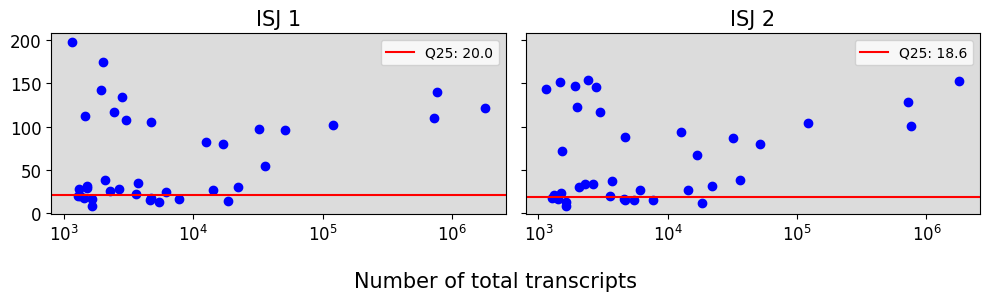

In [12]:
maxt = int(np.ceil(np.log10(np.max(tsize))))
fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=(10,3))
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].scatter(np.log10(tsize[mask]), (metatrans.iloc[mask,i]), c='b')
    ax[i].set_xticks(range(3,maxt), ['10$^{}$'.format(i) for i in range(3,maxt)])
    ax[i].tick_params(labelsize=fs-3)
    ax[i].set_title('ISJ {}'.format(i+1), fontsize=fs)
    ax[i].axhline(isj[i], c='r', label='Q25: {:.1f}'.format(isj[i]))
    ax[i].legend()
    ax[i].set_facecolor('gainsboro')

fig.supxlabel('Number of total transcripts', fontsize=fs)
fig.tight_layout();

# Compute transcript weights for KDE

In [12]:
top, right, bottom, left = cardinal_distance_transform(wall)

In [13]:
pp = 0
wv = stats.norm.cdf(top[translocs['Y'].values, translocs['X'].values]+pp, loc=0, scale=bw)
wv-= stats.norm.cdf(-bottom[translocs['Y'].values, translocs['X'].values]-pp, loc=0, scale=bw)

wh = stats.norm.cdf(right[translocs['Y'].values, translocs['X'].values]+pp, loc=0, scale=bw) 
wh-= stats.norm.cdf(-left[translocs['Y'].values, translocs['X'].values]-pp, loc=0, scale=bw)

weight = 2-(wv*wh)

# Select a transcript and a cell

In [26]:
foo = metacell.sort_values(by='c2t_area_ratio')
bar = foo.index.values
print(bar[:20])

[ 217 1852  627  121 2110 1765 1748  267  390 1825 1006  315 2610 2000
 1124  849  925 1656  733 2553]


In [27]:
print(transcell['{}'.format(bar[5]+1)].sort_values(ascending=False)[:10])

26    258
16    118
62     43
57     27
58     21
77     18
25     10
84      9
75      8
66      7
Name: 1766, dtype: int64


In [28]:
tidx = 26

tmask = invidx == tidx
coords = translocs.loc[ tmask , ['X', 'Y'] ].values.T
print(transcriptomes[tidx], metatrans.iloc[tidx]['cyto_number'], sep='\t')
kdst = dst + transcriptomes[tidx] + os.sep
if not os.path.isdir(kdst):
    os.mkdir(kdst)
ratios = transcell.iloc[tidx, :-1].values.astype(float) / metatrans.loc[tidx, 'cyto_number']
#transcell.iloc[tidx, :-1].sort_values(ascending=False).iloc[:10]

GLYMA_05G092200	764847


In [62]:
PP = 6
cidx = bar[6]

cmask = label[ coords[1], coords[0] ] == cidx + 1
ccoords = coords[:, cmask ].copy()
print(cidx, ccoords.shape, sep='\t')
ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cell = wall[ss].copy().astype(np.uint8)
cell[ label[ss] == cidx+1 ] = 2
cell[~wall[ss]] = 0

1748	(2, 350)


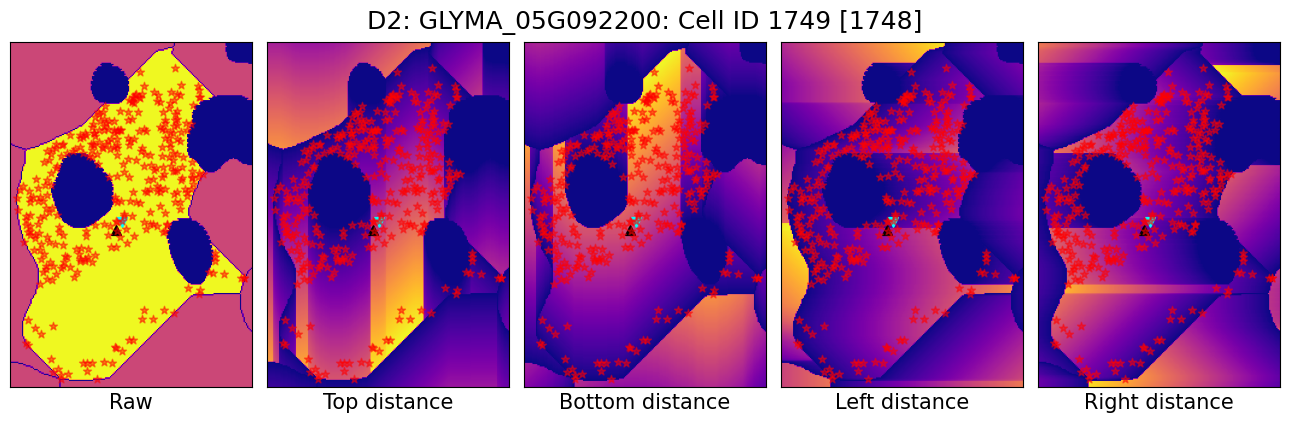

In [46]:
figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'
fig, ax = plt.subplots(1,5,figsize=(13,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(cell, cmap='plasma', origin='lower', extent=extent)
ax[1].imshow(top[ss], cmap='plasma', origin='lower', extent=extent)
ax[2].imshow(bottom[ss], cmap='plasma', origin='lower', extent=extent)
ax[3].imshow(left[ss], cmap='plasma', origin='lower', extent=extent)
ax[4].imshow(right[ss], cmap='plasma', origin='lower', extent=extent)

for i in range(len(ax)):
    ax[i].set_aspect('equal')
    ax[i].margins(0)    
    ax[i].scatter(*metacell.iloc[cidx, [10,11]].values, c='cyan', marker='v', zorder=2, s=50) # original
    ax[i].scatter(*metacell.iloc[cidx, [12,13]].values, c='black', marker='^', zorder=2, s=50) # ndimage
    ax[i].scatter(ccoords[0], ccoords[1], c='red', marker='*', zorder=3, alpha=0.5);
    ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

i = 0
ax[i].set_xlabel('Raw', fontsize=fs); i+=1
ax[i].set_xlabel('Top distance', fontsize=fs); i+=1
ax[i].set_xlabel('Bottom distance', fontsize=fs); i+=1
ax[i].set_xlabel('Left distance', fontsize=fs); i+=1
ax[i].set_xlabel('Right distance', fontsize=fs); i+=1

title = '{}: {}: Cell ID {} [{}]'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'], cidx)
fig.suptitle(title, fontsize=18, y=0.87)
fig.tight_layout()

#filename = figdst + '{}_{}_{}_{}_distance_transform'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'], cidx)
#plt.savefig(filename + '.jpg', format='jpg', dpi=150, bbox_inches='tight', pil_kwargs={'optimize':True})

# Prepare the KDE grid

In [56]:
stepsize = 5
xaxis, yaxis, grid, gridmask = kde_grid_generator(stepsize, cell.shape, pows2)

grid = grid + np.array([ss[1].start, ss[0].start])
X,Y = np.meshgrid(xaxis, yaxis)
xaxis += ss[1].start; yaxis += ss[0].start    

In [57]:
#bw = np.mean(isj)
bw = 15
uwkde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(ccoords.T).evaluate(grid)
uwkde = uwkde[gridmask]/(np.sum(uwkde[gridmask])*stepsize*stepsize)
uwkde = uwkde.reshape( ( len(yaxis), len(xaxis) ), order='F')
print(np.sum(uwkde)*stepsize*stepsize)
maxuwkde = np.max(uwkde)

1.0000000000000002


In [58]:
w = weight[tmask][cmask]
kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(ccoords.T, w).evaluate(grid)
kde = kde[gridmask]/(np.sum(kde[gridmask])*stepsize*stepsize)
cgrid = grid[gridmask] - np.array([ss[1].start, ss[0].start])
kde[ cell[cgrid[:,1],cgrid[:,0]] != 2 ] = 0
kde = kde/(np.sum(kde)*stepsize*stepsize)
kde = kde.reshape( ( len(yaxis), len(xaxis) ), order='F')
print(np.sum(kde)*stepsize*stepsize)
maxkde = np.max(kde)

diff = kde - uwkde
maxd = np.max(np.abs(diff))/2
vmax = max([maxkde, maxuwkde])

1.0


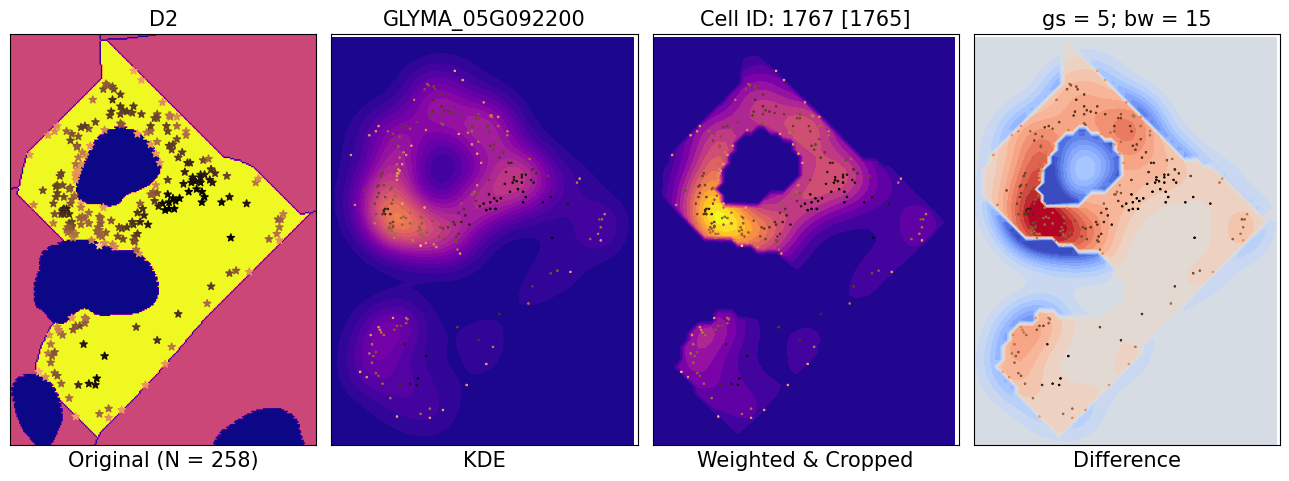

In [59]:
fs = 15
fig, ax = plt.subplots(1,4,figsize=(13,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i=0

ax[i].imshow(cell, cmap='plasma', origin='lower', extent=extent)
ax[i].scatter(ccoords[0], ccoords[1], c=w, cmap='copper', marker='*', zorder=3, s=30, alpha=1); i += 1
for density in [uwkde,kde]:
    ax[i].contourf(xaxis,yaxis, density, 16, cmap='plasma', vmin=0, vmax=vmax, zorder=1); i += 1
ax[i].contourf(xaxis, yaxis, diff, 32, cmap='coolwarm', vmin=-maxd, vmax=maxd)
for i in [1,2,3]:
    #ax[i].scatter(bcoords[1], bcoords[0], c='lime', marker='.', s=1, alpha=1, zorder=2)
    ax[i].scatter(ccoords[0], ccoords[1], c=w, cmap='copper', marker='*', s=1, alpha=1, zorder=3)
for i in range(len(ax)):
    ax[i].set_aspect('equal')
    ax[i].margins(0)
    ax[i].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    
ax[0].set_xlabel('Original (N = {})'.format(len(ccoords[0])), fontsize=fs)
ax[1].set_xlabel('KDE', fontsize=fs)
ax[2].set_xlabel('Weighted & Cropped', fontsize=fs)
ax[3].set_xlabel('Difference', fontsize=fs)

ax[0].set_title('{}'.format(sample), fontsize=fs)
ax[1].set_title(transcriptomes[tidx], fontsize=fs)
ax[2].set_title('Cell ID: {} [{}]'.format(metacell.loc[cidx, 'orig_cellID'], cidx), fontsize=fs)
ax[3].set_title('gs = {}; bw = {}'.format(stepsize, bw), fontsize=fs)

fig.tight_layout();

#filename = figdst + '{}_{}_{}_{}_kde_correction'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'], cidx)
#plt.savefig(filename + '.jpg', format='jpg', dpi=150, bbox_inches='tight', pil_kwargs={'optimize':True})

# Save results

In [209]:
meta = [cidx, PP, stepsize, bw, vmax]
filename = kdst + 'c{}_p{}_s{}_b{}_m{:.25E}.npy'.format(*meta)
print(filename)
np.save(filename, kde)

../kde/D2/GLYMA_05G092200/GLYMA_05G092200_c11_p6_s5_b15_m1.1552999145936335059076105E-04.npy


In [200]:
cell.shape

(152, 289)

# Generate TIF

In [205]:
cellcoords = np.asarray(np.nonzero(label == cidx + 1))

In [206]:
ratio = transcell.iloc[tidx,cidx]/metatrans.iloc[tidx,3]
interp = interpolate.RegularGridInterpolator((yaxis, xaxis), kde, method='linear', bounds_error=True, fill_value=None)
bins = np.linspace(0, kde.max(), 256)
cvals = interp(cellcoords.T)
cpdf = np.zeros(cell.shape)
cpdf[cellcoords[0]-ss[0].start, cellcoords[1] - ss[1].start] = cvals
dig = np.digitize(cpdf, bins, right=True).astype(np.uint8)

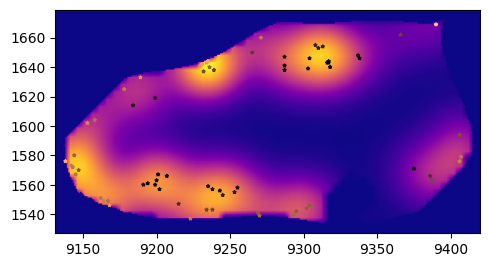

In [207]:
fs = 15
fig, ax = plt.subplots(1,1,figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(dig, cmap='plasma', origin='lower', extent=extent)
ax[0].scatter(ccoords[0], ccoords[1], c=weight, cmap='copper', marker='*', zorder=3, s=5, alpha=1); i = 1
    
fig.tight_layout();

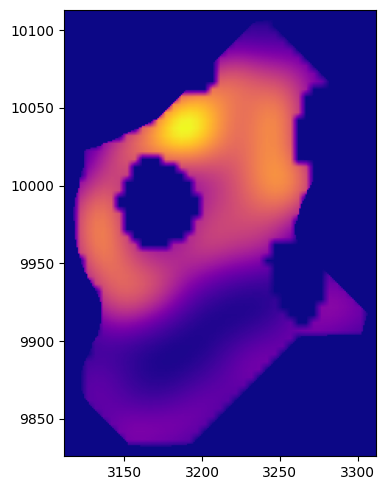

In [156]:
fs = 15
fig, ax = plt.subplots(1,1,figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(dig, cmap='plasma', origin='lower', extent=extent)
#ax[0].scatter(ccoords[0], ccoords[1], c=weight, cmap='copper', marker='*', zorder=3, s=20, alpha=1); i = 1
    
fig.tight_layout();